In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

In [42]:
PROJECT_ROOT = Path("..").resolve()

def process_pipeline():
   
    DATA_DIR = PROJECT_ROOT / "data" / "raw"
    train_path = DATA_DIR / "train.csv"
    test_path = DATA_DIR / "test.csv"

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    X_test = test_df.drop(columns=["id"])

    train_df["Heart Disease"]=train_df["Heart Disease"].map({"Presence":1,"Absence":0})
    train_df = train_df.drop(columns=["id"])

    X=train_df.iloc[:,0:-1]
    Y=train_df.iloc[:,-1]

    return X,Y,X_test

In [43]:
X,Y,X_test = process_pipeline()

In [48]:
model = mlflow.sklearn.load_model("models:/stacking_heart_disease_model/1")
preds = model.decision_function(X)


In [47]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_scores = np.zeros(len(X))
test_scores = np.zeros(len(X_test))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, Y)):
    
    print(f"\nFold {fold+1}")
    
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = Y.iloc[train_idx], Y.iloc[valid_idx]
    
    model.fit(X_train, y_train)
    
    # VALIDATION DECISION SCORES
    oof_scores[valid_idx] = model.decision_function(X_valid)
    
    # TEST DECISION SCORES
    test_scores += model.decision_function(X_test) / skf.n_splits


# 🔥 Convert scores → probabilities (sigmoid)
oof_preds = 1 / (1 + np.exp(-oof_scores))
test_preds = 1 / (1 + np.exp(-test_scores))


# Save for later threshold tuning
np.save("oof_preds.npy", oof_preds)
np.save("test_preds.npy", test_preds)

print("\n✅ OOF and Test predictions saved successfully.")


Fold 1


CatBoostError: catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

In [45]:

final_predictions =  1 / (1 + np.exp(-preds))



In [46]:
final_predictions

array([0.72992923, 0.27261027, 0.27297347, ..., 0.67683731, 0.48550701,
       0.2706767 ], shape=(630000,))

Best Threshold : 0.4574
Best F1 Score  : 0.8780
Precision      : 0.8615
Recall         : 0.8952


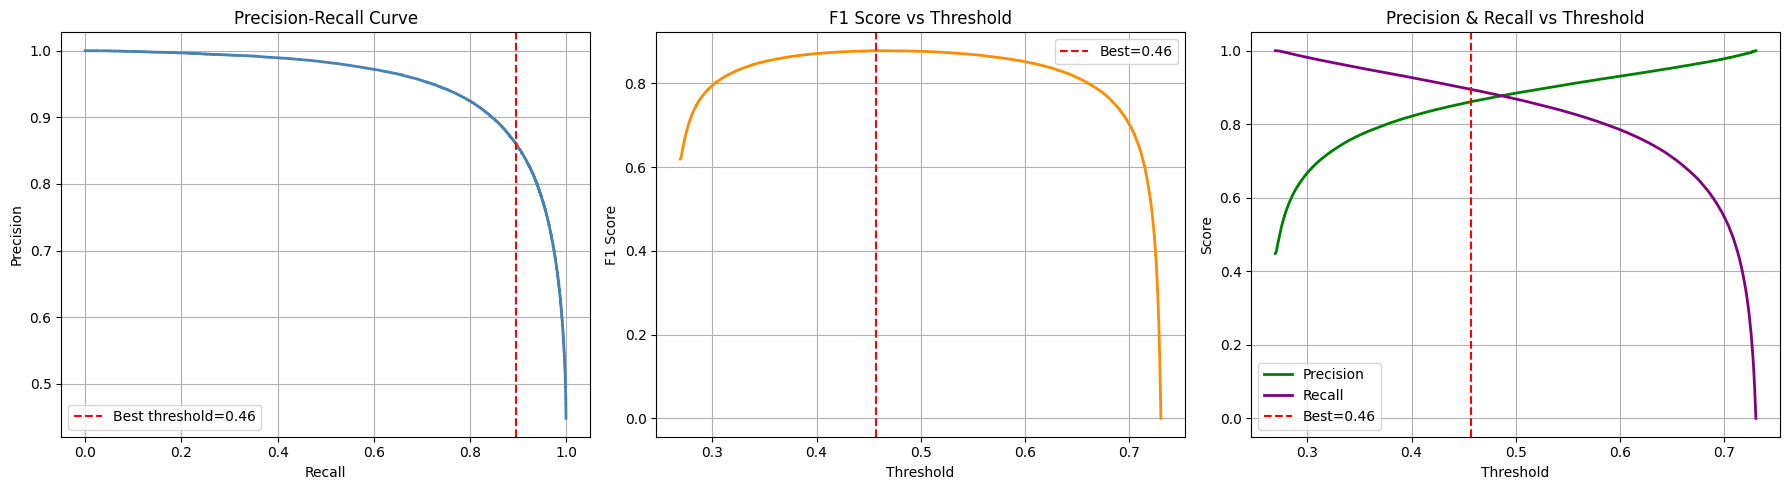


Class distribution: [336475 293525]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve, auc

probs = final_predictions   

precision, recall, thresholds = precision_recall_curve(Y, probs)

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold : {best_threshold:.4f}")
print(f"Best F1 Score  : {f1_scores[best_idx]:.4f}")
print(f"Precision      : {precision[best_idx]:.4f}")
print(f"Recall         : {recall[best_idx]:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(recall, precision, color='steelblue', lw=2)
axes[0].axvline(recall[best_idx], color='red', linestyle='--', label=f'Best threshold={best_threshold:.2f}')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(thresholds, f1_scores, color='darkorange', lw=2)
axes[1].axvline(best_threshold, color='red', linestyle='--', label=f'Best={best_threshold:.2f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score vs Threshold')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(thresholds, precision[:-1], label='Precision', color='green', lw=2)
axes[2].plot(thresholds, recall[:-1], label='Recall', color='purple', lw=2)
axes[2].axvline(best_threshold, color='red', linestyle='--', label=f'Best={best_threshold:.2f}')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Score')
axes[2].set_title('Precision & Recall vs Threshold')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

final_labels = (probs >= best_threshold).astype(int)
print(f"\nClass distribution: {np.bincount(final_labels)}")

In [ ]:
# - BEST THRESHOLD : 0.4574